# Simulacion - 75.26
## TP1 - Xorshift RNGs
### Grupo 4 
### Integrantes: Joaquín Rivero, Juan Pablo Aschieri, Diego Civini, Francisco Rovira Rossel

In [147]:
import matplotlib.pyplot as plt

## Ejercicio 1

Hacemos una clase `xorshift_generator` que dada una semilla devuelve un generador de numeros aleatorios de 32 bits realizando operaciones logicas de shifteo y xor. Los valores usados para la cantidad de shifteos fueron sacados del paper.

In [148]:
class xorshift_generator:
    def __init__(self, seed):
        self.x = seed
        self.y = 463820370
        self.z = 138409373
        self.w = 12872349


    def rand(self):
        tmp = ( self.x^ (self.x <<13) ) 
        self.x = self.y
        self.y = self.z
        self.z = self.w
        self.w = (self.w^(self.w>>17) ) ^ (tmp^(tmp>>5))
        return self.w & 0xffffffff
    
    def normalized_rand(self):
        return self.rand() / (2**32 -1)

Obtenemos un generador con una semilla y obtenemos 100000 numeros para analizar los resultados.

In [149]:
generator = xorshift_generator(123456789)

In [150]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.rand())
print(rand_numbers[:5])

[634047618, 827895943, 4188086042, 2971408131, 1743656811]


Graficamos los numeros en un histograma para obtener una representacion visual aproximada de su distribucion. Como buscamos numeros aleatorios entre 0 y 2^32 -1 deberia ser un grafico similar a una dist uniforme ente 0 y 2^32 -1

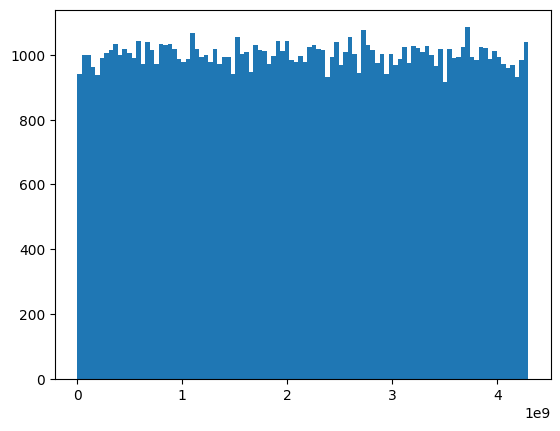

In [151]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Si bien no es perfecto se puede ver como aproximadamente los distintos box tienen la misma cantidad de ocurrencias, haciendo que el grafico dado se paresca a una meseta, que es el grafico que deberia tener una uniforme.

Si queremos obtener numero aleatorios entre 0 y 1 utilizando el xorshift generator, basta con generar un numero aleatorio de la misma manera y luego normalizarlo. Para ello dividimos al numero por el mayor valor posible, 2^32 -1. De esta manera optenemos un numero aleatorio entre 0 y 1 con el metodo normalized_rand

In [152]:
rand_numbers_normalized = []
for i in range(100000):
    rand_numbers_normalized.append(generator.normalized_rand())
print(rand_numbers_normalized[:5])

[0.24394065706151088, 0.5719659192422325, 0.2779104933789723, 0.8770274484709435, 0.9444620914162282]


De la misma forma graficamos un histograma para ver si la distribucion de los numeros se asemeja a una distribucion uniforme entre 0 y 1.

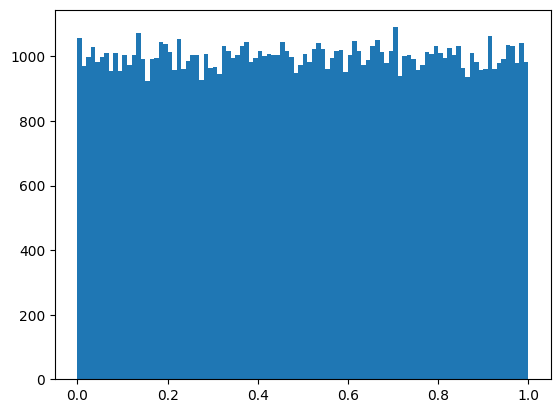

In [153]:
plt.hist(rand_numbers_normalized, bins = 100)
plt.show()

## Ejercicio 2

enunciado

### Test chi2


Si bien el test dela chi2 necesita que la dist sea discreta, nosotros tenes una distribucion continua, uniforme. Esto presenta un problema, sin se puede resolver facilmente. Para poder realizar este test, podemos discretizar la distribucion juntando valores de intervalos en bins. En este caso vamos a usar 100 bins.

Este test nos permite saber con un nivel de significacion alfa (usaremos 0.05) si los valores que generamos NO tienen distribucion uniforme. Para ello tomamos como hipotesis nula que la distribucion es uniforme en el intervalo correspondiente. Si se rechaza la hipotesis entonces afirmaremos que no es uniforme. Sin embargo de no ser uniforme esto no nos permite decir que la distribucion es uniforme.

Tomo como h0 que la dist es uniforme. Este test NO SIRVE para decir si una dist es uniforme. Sirve para decir, si se rechaza h0 puedo decir con un nivel de significacion alfa que la dist no es uniforme. Si no se rechaza H0 entonce NO ES QUE ES UNIFORME, si no que PUEDE ser uniforme.

In [201]:
from scipy.stats import chi2

In [202]:
def get_frequency(rand_numbers, bins, max):
    frequency = [0 for i in range(bins)]
    bin_size = max/bins

    for i in rand_numbers:
        j = 0
        seguir = True
        while seguir:
            if i < bin_size:
                frequency[j] += 1
                seguir = False
            else:
                j += 1
                i -= bin_size

    return frequency

In [203]:
def test_chi2_for_uniform_distribution(rand_numbers, bins, max, significance_level):
    frequency = get_frequency(rand_numbers, bins, max)

    expected_frecuency = len(rand_numbers)/bins
    aux = 0
    for i in frequency:
        aux += (i - expected_frecuency)**2
    d2 = aux/expected_frecuency

    upper_limit = chi2.ppf(1 - significance_level, df=bins-1)

    print(f"D2: {d2}")
    print(f"Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: {upper_limit}")
    if d2 > upper_limit:
        print("Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05")
    else:
        print("No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme")

In [204]:
int((2**32-1)/100)


42949672

Creamos un xorshift generator y le aplicamos el test de la chi2 para tanto el generador de numeros entre 0 y 2^32-1 y el de numeros entre 0 y 1, probando generar 1000, 10000 y 100000 numeros.

In [205]:
generator = xorshift_generator(565555555)

#### Pruebas para generador

Probamos el generador con una muestra de 100 numeros

In [206]:
rand_numbers =[]
for i in range(100):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 64.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Esto se debe a que no hay grandes diferencias entre los distintos bins. Como se muestra en el siguiente grafico.

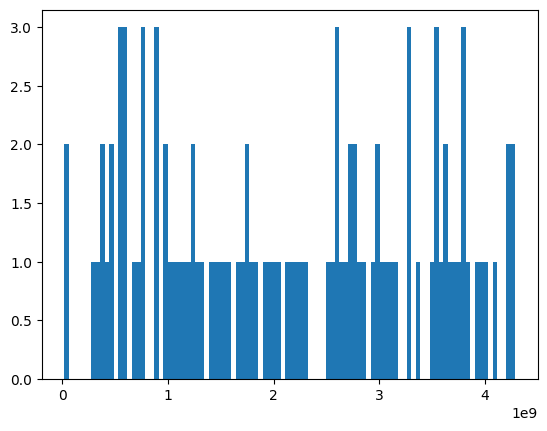

In [207]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Sin embargo esto depende enteramente de la suerte que tengamos al generar la muestra, yo que a pesar de que sea poco probable, se podria dar el caso de que los 100 numeros estan en el mismo bin. Por ejemplo en el siguiente caso

In [208]:
#dejamos pasar 100 numeros de la semilla
for i in range(300):
    generator.rand()

rand_numbers =[]
for i in range(100):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 132.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


En este caso vemos que se rechaza h0, es decir que podemos asegurar bajo un nivel de significancia 0.05 que la distribucion no es de tipo uniforme. Sin embargo esto se debe a que tuvimos "mala suerte" a la hora de obtener los numeros. Lo que se ve en el sigueinte grafico que contiene muchas mas irregularidades que el anterior

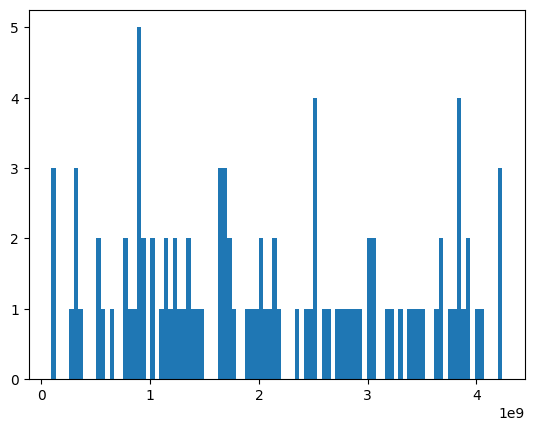

In [209]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Para evitar que nuestros resultados esten muy influenciados por la "suerte" que tengamos al obtener numeros, los generamos en magnitudes mas grandes, esto hara que sea mucho menos probable que el test de que se rechaza la hipotesis nula por "mala suerte."

Probamos el generador con una muestra de 10000 numeros

In [210]:
rand_numbers =[]
for i in range(10000):
    rand_numbers.append(generator.rand())

test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 92.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 10000 numeros

In [211]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 2**32 - 1, 0.05)

D2: 111.282
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


#### Pruebas para generador normalizado

A partir de aquí, se prueba el generador para numeros randoms entre 0 y 1, para 100, 10000 y 100000 numeros. Es muy similar a lo obtenido en el caso anterior ya que para generat numeros entre 0 y 1 se utiliza el generador testeado anteriormente.

In [212]:
rand_numbers = []
for i in range(100):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 100.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


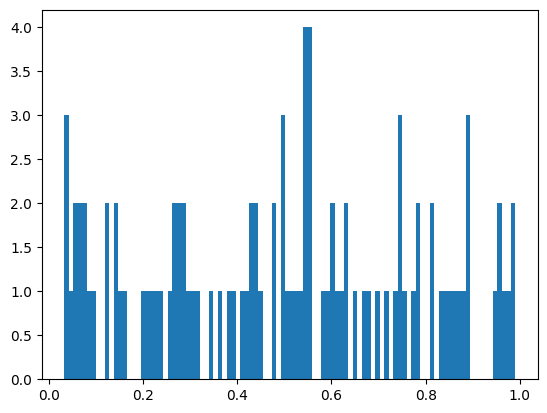

In [213]:
plt.hist(rand_numbers, bins = 100)
plt.show()

De la misma manera que en el generador anterior, al ser muy pocos los numeros que generamos nuestro test tiene altas chances de dar resultados diferentes segun que tanta "suerte" tengamos al generar los 100 numeros

In [214]:
rand_numbers = []
for i in range(100):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 130.0
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
Hay suf evidencia para rechazar h0, es decir que podemos afirmar que la distribucion no es uniforme con un nivel de significacion de 0.05


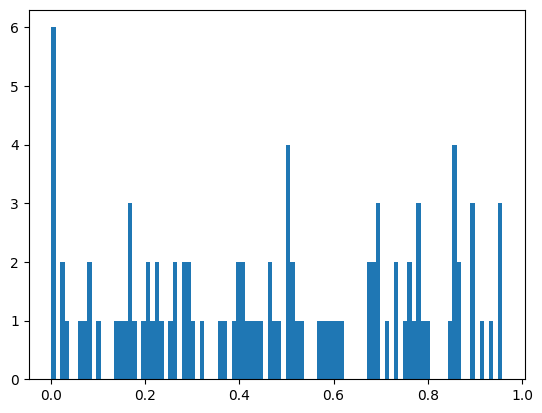

In [215]:
plt.hist(rand_numbers, bins = 100)
plt.show()

Probamos el generador con una muestra de 10000 numeros

In [216]:
rand_numbers = []
for i in range(10000):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 92.48
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


Probamos el generador con una muestra de 100000 numeros

In [217]:
rand_numbers = []
for i in range(100000):
    rand_numbers.append(generator.normalized_rand())
test_chi2_for_uniform_distribution(rand_numbers, 100, 1, 0.05)

D2: 80.902
Valor del cuantil de una Chi-cuadrado de (bins-1) grados de libertad: 123.2252214533618
No hay suf evidencia para rechazar h0, es decir que la distribucion podria ser uniforme


### Test TCL